### import libary

In [1]:
import torch
import torch.nn as nn

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import PIL
from PIL import Image

import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import cv2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("Pillow Version: ", PIL.__version__)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

path = "checkpoint.pt"

PyTorch Version:  2.2.2+cpu
Torchvision Version:  0.17.2+cpu
Pillow Version:  10.2.0
CUDA is not available.  Training on CPU ...


In [2]:
# pip install opencv-python

### load model

In [3]:
# Generalized-Mean Pooling (GeM)
# avgpool -> p-norm pooling

class GeM(nn.Module):
    def __init__(self, p=3.0, eps=1e-6): 
        super().__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return F.adaptive_avg_pool2d(x.clamp(min=self.eps).pow(self.p), (1,1)).pow(1./self.p)

In [4]:
# 모델 구조 불러오기
model = models.resnet18(weights=None, num_classes=42)

model.avgpool = GeM()

state_dict = torch.load(
    path,
    map_location=torch.device('cpu'),
    weights_only=True
)
model.load_state_dict(state_dict)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### start

In [5]:
# 사전 생성한 patch 불러오기
patch = torch.load("./adv_patch.pt").to(device)  # (3, P, P)

In [ ]:
# 타겟 이미지 목록
image_paths = [
    "./sample_bart/pic_0081.jpg",
    "./sample_bart/pic_0186.jpg",
    "./sample_bart/pic_0403.jpg",
]

In [7]:
# 전처리
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std= [0.229,0.224,0.225])
])

# De-normalize + ToPIL (for visualization)
inv_norm = transforms.Normalize(
    mean=[-m/s for m,s in zip([0.485,0.456,0.406],
                              [0.229,0.224,0.225])],
    std=[1/s for s in [0.229,0.224,0.225]]
)
to_pil = transforms.ToPILImage()

In [8]:
def compute_shirt_mask_and_bbox(pil_img, threshold=30):
    """PIL RGB 이미지를 받아 color‐distance로 shirt mask + bbox 리턴."""
    img_np = np.array(pil_img)
    # 참조 색 좌표 설정정
    h, w, _ = img_np.shape
    ref_rgb = img_np[2*h//3, w//2]
    # BGR→LAB
    bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    ref_lab = cv2.cvtColor(
        np.uint8([[ref_rgb[::-1]]]), cv2.COLOR_BGR2LAB
    )[0,0]
    # 거리 계산
    dist = np.linalg.norm(lab.astype(float) - ref_lab, axis=2)
    mask = dist < threshold
    # Morphology 정제
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    mask = cv2.morphologyEx(mask.astype(np.uint8),
                            cv2.MORPH_CLOSE, kernel).astype(bool)
    # Contour → bbox
    cnts, _ = cv2.findContours(mask.astype(np.uint8),
                               cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key=lambda c: cv2.contourArea(c))
    x, y, w_, h_ = cv2.boundingRect(cnt)
    return mask, (x, y, x+w_, y+h_)

In [9]:
# LabelEncoder 로드
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

In [10]:
def apply_patch_on_shirt(img_t: torch.Tensor,
                        patch:   torch.Tensor,
                        mask_np: np.ndarray,
                        alpha:   float = 1.0):
    """
    Apply patch according to mask shape, tiling patch over mask region.
    
    img_t:   (3, H, W) normalized tensor
    patch:   (3, P_h, P_w) tensor
    mask_np: (H, W) bool numpy array
    alpha:   blending factor 0~1
    """
    device = img_t.device
    C, H, W = img_t.shape
    _, P_h, P_w = patch.shape

    # Convert mask to torch boolean tensor
    mask_t = torch.from_numpy(mask_np).to(device)

    # Get coordinates of mask True pixels
    ys, xs = torch.nonzero(mask_t, as_tuple=True)  # each of shape (N,)

    # Tile patch over mask positions using modulo
    # For each mask position (y, x), get corresponding patch pixel at (y % P_h, x % P_w)
    # Expand dimensions for broadcasting
    patch_expanded = patch[:, ys % P_h, xs % P_w]  # shape (3, N)
    orig_pixels = img_t[:, ys, xs]                 # shape (3, N)

    # Blend
    blended = alpha * patch_expanded + (1 - alpha) * orig_pixels  # (3, N)

    # Create output tensor
    out = img_t.clone()
    out[:, ys, xs] = blended

    return out

In [11]:
def predict(model, img_t):
    with torch.no_grad():
        logits = model(img_t.unsqueeze(0))
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    idx = probs.argmax()
    name = label_encoder.inverse_transform([idx])[0]
    conf = probs[idx] * 100
    
    return name, conf

./data/pic_0081.jpg
  원본 → bart_simpson (100.0%)
  패치 → bart_simpson (95.5%)



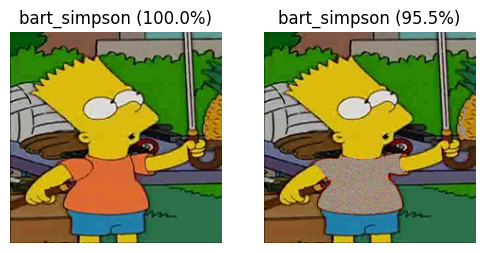

./data/pic_0186.jpg
  원본 → bart_simpson (100.0%)
  패치 → bart_simpson (100.0%)



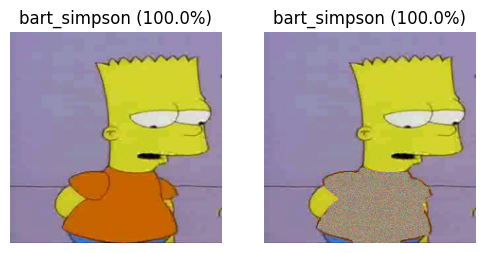

./data/pic_0403.jpg
  원본 → bart_simpson (100.0%)
  패치 → bart_simpson (99.7%)



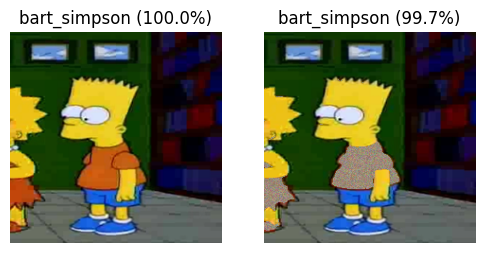

In [12]:
# 이미지별로 마스크 생성 → 패치 적용 → 예측 & 시각화
for path in image_paths:
    # 이미지 로드 → PIL → preprocess → tensor
    pil = Image.open(path).convert("RGB").resize((224,224))
    img_t = preprocess(pil).to(device)

    # mask, bbox 생성
    mask, bbox = compute_shirt_mask_and_bbox(pil, threshold=30)

    # 원본 이미지 예측
    orig_name, orig_conf = predict(model, img_t)

    # 패치 적용
    patched = apply_patch_on_shirt(img_t, patch, mask, alpha=0.9)

    # 패치된 이미지 예측
    patched_name, patched_conf = predict(model, patched)

    # f) 결과 출력
    print(f"{path}")
    print(f"  원본 → {orig_name} ({orig_conf:.1f}%)")
    print(f"  패치 → {patched_name} ({patched_conf:.1f}%)\n")

    # g) 시각화: 원본 vs. 패치된 이미지
    fig, axes = plt.subplots(1,2,figsize=(6,3))
    axes[0].imshow(to_pil(inv_norm(img_t.cpu())))
    axes[0].set_title(f"{orig_name} ({orig_conf:.1f}%)")
    axes[0].axis("off")
    axes[1].imshow(to_pil(inv_norm(patched.cpu())))
    axes[1].set_title(f"{patched_name} ({patched_conf:.1f}%)")
    axes[1].axis("off")
    plt.show()